# Fast Gaussian Process Regression

In [1]:
import qmcpy as qp 
import torch 
import numpy as np 
import scipy.stats
import pandas as pd
from matplotlib import pyplot,cm,colors

In [2]:
pyplot.style.use("seaborn-whitegrid")
LW = 3
CISIZE = .95
ZSTAR = scipy.stats.norm.ppf(CISIZE+(1-CISIZE)/2)
MARKERSIZE = 50
CMAP = cm.inferno
ALPHA = .5
COLORS = ["xkcd:"+color[:-1] for color in pd.read_csv("./xkcd_colors.txt",comment="#").iloc[:,0].tolist()][::-1]

In [3]:
torch.set_default_dtype(torch.float64)
DEVICE = "cpu"

In [20]:
def f_grad_f(f,x):
    assert x.ndim==2
    d = x.shape[1]
    xs = [x[:,j] for j in range(d)]
    for j in range(d): xs[j].requires_grad_()
    x = torch.vstack(xs).T
    y = f(x)
    grad = [None]*d 
    for j in range(d):
        grad[j] = torch.autograd.grad(y,xs[j],grad_outputs=torch.ones_like(y),create_graph=True)[0]
    y_grad_y = torch.vstack([y]+grad).T 
    return y_grad_y.detach()
def f_curve_1d(x):
    return np.pi*x[:,0]*torch.sin(4*np.pi*x[:,0])*torch.exp(-.01/(1/2-torch.abs(x[:,0]-1/2)))
def f_G(x): # GFunction from https://www.sfu.ca/~ssurjano/gfunc.html
    assert x.ndim==2
    d = x.shape[1] 
    a = (torch.arange(1,d+1,device=DEVICE)-2)/2
    y = torch.prod((torch.abs(4*x-2)+a)/(1+a),dim=1)
    return y
def f_peaks(x): # peaks function 
    x = 6*x-3
    x1,x2 = x[:,0],x[:,1]
    t1 = 3*(1-x1)**2*torch.exp(-x1**2-(x2+1)**2)
    t2 = 10*(x1/5-x1**3-x2**5)*torch.exp(-x1**2-x2**2)
    t3 = 1/3*torch.exp(-(x1-1)**2-x2**2)
    return t1-t2-t3
def f_ackley(x, a=20, b=0.2, c=2*np.pi, scaling=32.768): # https://www.sfu.ca/~ssurjano/ackley.html
    x = 2*scaling*x-scaling
    t1 = a*torch.exp(-b*torch.sqrt(torch.mean(x**2,1)))
    t2 = torch.exp(torch.mean(torch.cos(c*x),1))
    t3 = a+np.exp(1)
    y = -t1-t2+t3
    return -y
def brownian_motion(t, seed=23, numklterms=250):
    # eq 6.8 https://artowen.su.domains/mc/Ch-processes.pdf
    j = torch.arange(numklterms)
    z_j = torch.from_numpy(np.random.Generator(np.random.PCG64(seed)).uniform(0,1,numklterms))
    bm = np.sqrt(2)/np.pi*(z_j*2/(2*j+1)*torch.sin((2*j+1)/2*np.pi*t)).sum(1)
    return bm

## Grid vs lattice vs digital net

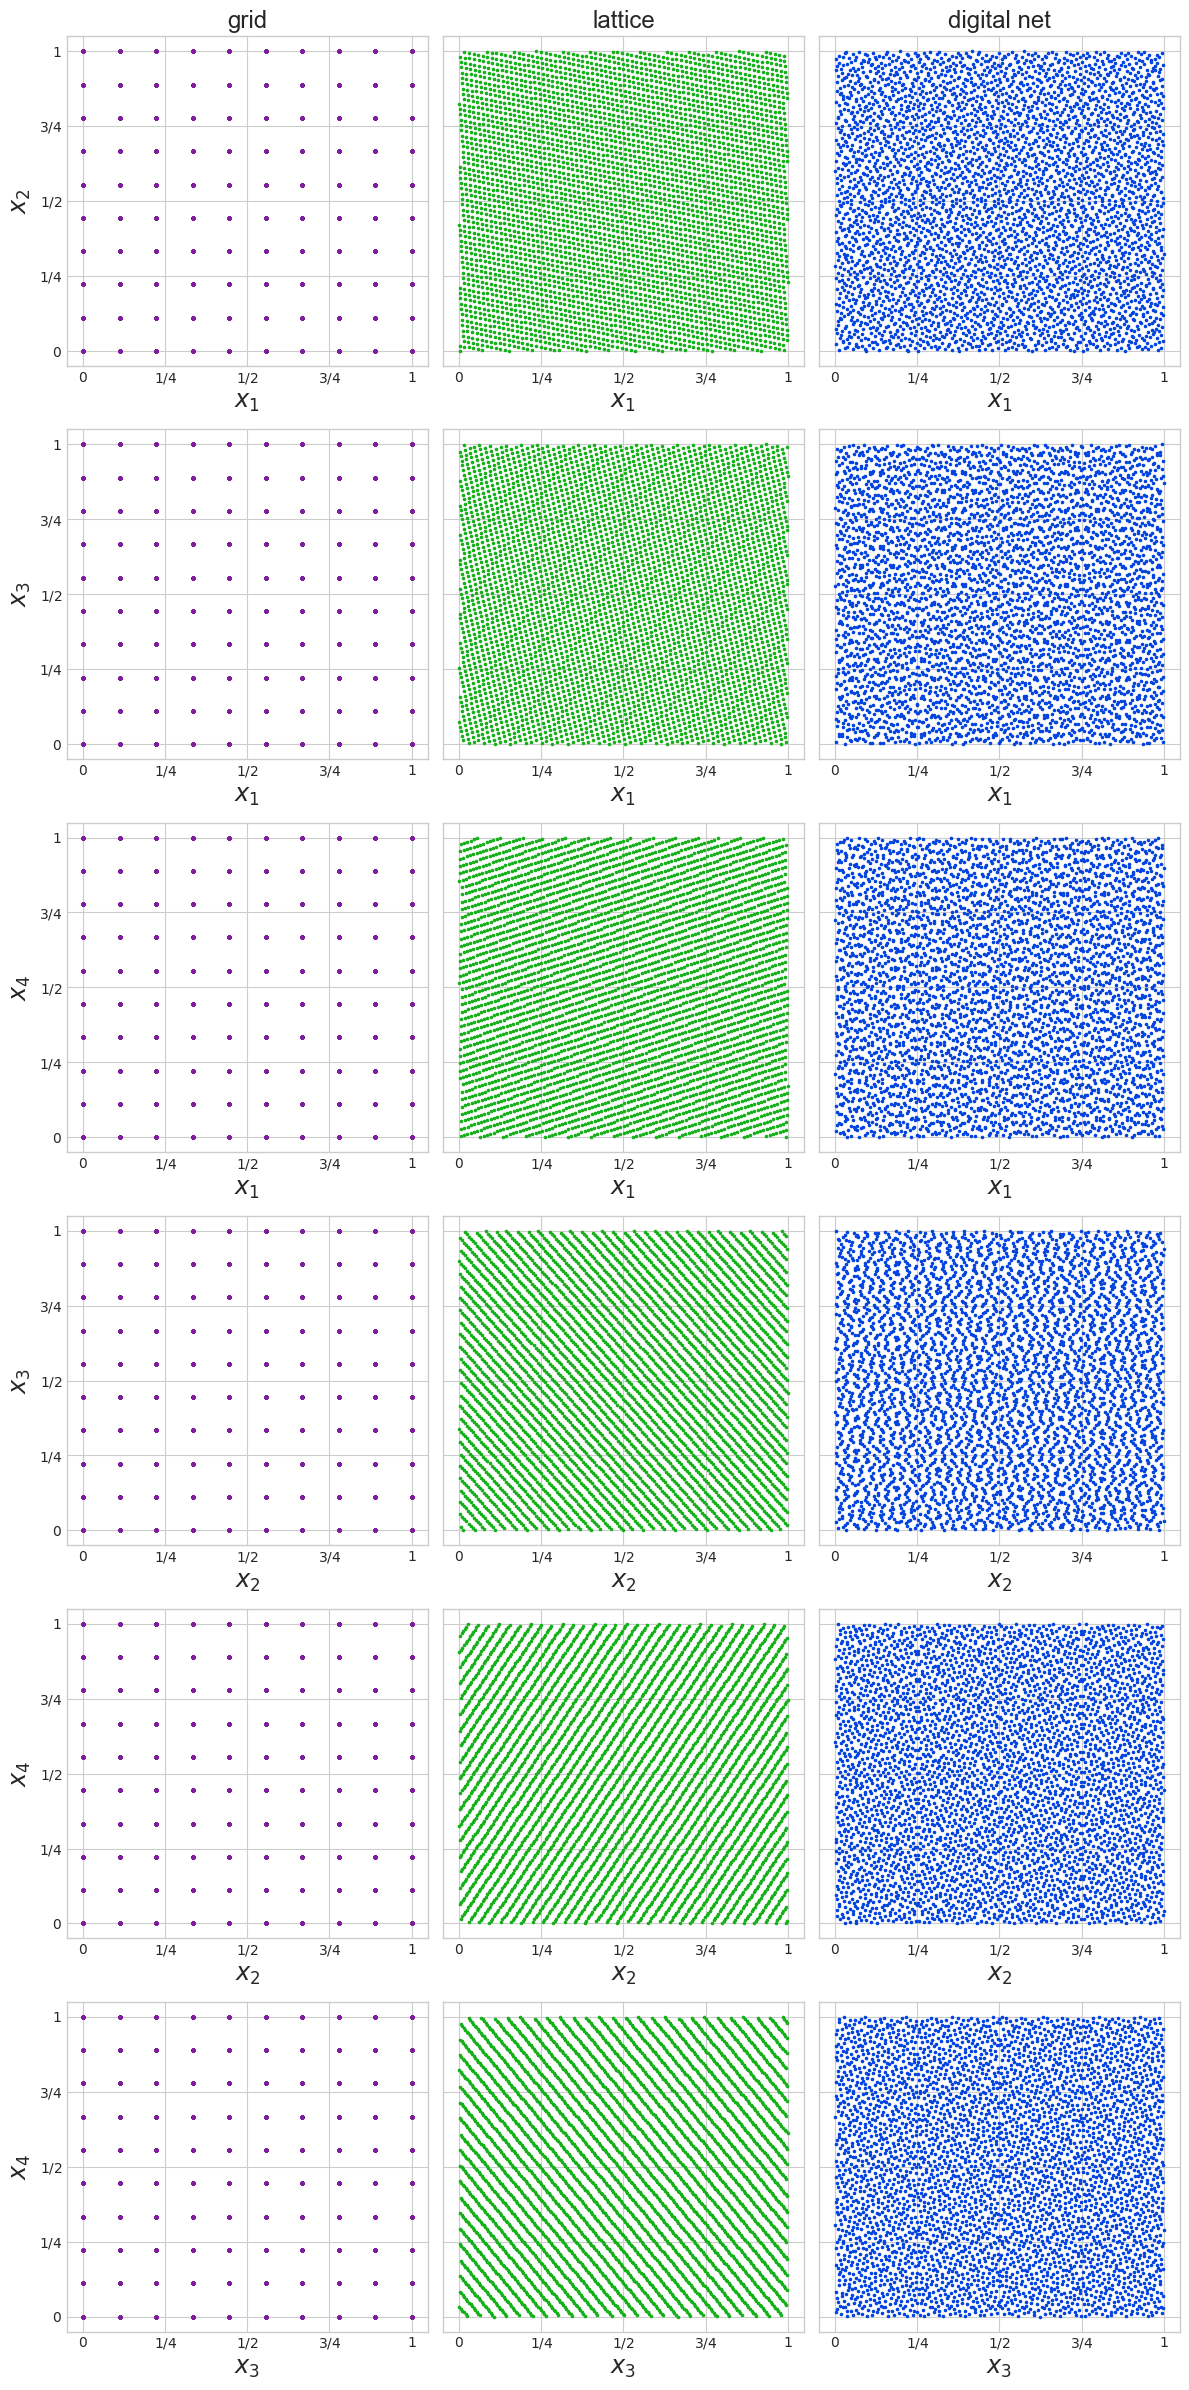

In [17]:
n = 2**12
d = 4
ngrid = n**(1/d)
assert ngrid%1==0
gridmesh = torch.meshgrid(*(torch.linspace(0,1,int(ngrid)+2) for j in range(d)),indexing="ij")
grid = torch.vstack([gridmesh[j].flatten() for j in range(d)]).T 
x_lattice = qp.Lattice(d,seed=7)(n)
x_dnb2 = qp.DigitalNetB2(d,seed=7)(n)
fig,ax = pyplot.subplots(nrows=6,ncols=3,figsize=(4*3,4*6),sharey="row")
S = 2.5
for j,(name,x) in enumerate(zip(["grid","lattice","digital net"],[grid,x_lattice,x_dnb2])):
    ax[0,j].set_title(name,fontsize="xx-large")
    ax[0,j].scatter(x[:,0],x[:,1],s=S,color=COLORS[j])
    ax[1,j].scatter(x[:,0],x[:,2],s=S,color=COLORS[j])
    ax[2,j].scatter(x[:,0],x[:,3],s=S,color=COLORS[j])
    ax[3,j].scatter(x[:,1],x[:,2],s=S,color=COLORS[j])
    ax[4,j].scatter(x[:,1],x[:,3],s=S,color=COLORS[j])
    ax[5,j].scatter(x[:,2],x[:,3],s=S,color=COLORS[j])
    ax[0,j].set_xlabel(r"$x_1$",fontsize="xx-large")
    ax[1,j].set_xlabel(r"$x_1$",fontsize="xx-large")
    ax[2,j].set_xlabel(r"$x_1$",fontsize="xx-large")
    ax[3,j].set_xlabel(r"$x_2$",fontsize="xx-large")
    ax[4,j].set_xlabel(r"$x_2$",fontsize="xx-large")
    ax[5,j].set_xlabel(r"$x_3$",fontsize="xx-large")
    for i in range(6):
        #ax[i,j].set_xlim([0,1])
        #ax[i,j].set_ylim([0,1])
        ax[i,j].set_xticks([0,1/4,1/2,3/4,1])
        ax[i,j].set_xticklabels([r"$0$",r"$1/4$",r"$1/2$",r"$3/4$",r"$1$"])
        ax[i,j].set_yticks([0,1/4,1/2,3/4,1])
        ax[i,j].set_yticklabels([r"$0$",r"$1/4$",r"$1/2$",r"$3/4$",r"$1$"])
ax[0,0].set_ylabel(r"$x_2$",fontsize="xx-large")
ax[1,0].set_ylabel(r"$x_3$",fontsize="xx-large")
ax[2,0].set_ylabel(r"$x_4$",fontsize="xx-large")
ax[3,0].set_ylabel(r"$x_3$",fontsize="xx-large")
ax[4,0].set_ylabel(r"$x_4$",fontsize="xx-large")
ax[5,0].set_ylabel(r"$x_4$",fontsize="xx-large")
fig.tight_layout()
fig.savefig("./fgpr_figs/points.pdf",dpi=256,bbox_inches="tight")

## 1d example

<function brownian_motion at 0x372ea5940>
	GP, Gaussian kernel, grid
	Fast GPR, SI kernel, lattice $\alpha = 2$
	Fast GPR, SI kernel, lattice $\alpha = 3$
	Fast GPR, SI kernel, lattice $\alpha = 4$
	Fast GPR, DSI kernel, digital net $\alpha = 2$
	Fast GPR, DSI kernel, digital net $\alpha = 3$
	Fast GPR, DSI kernel, digital net $\alpha = 4$
	GP + derivative, Gaussian kernel, grid
	Fast GP + derivative, SI kernel, lattice $\alpha = 3$
	Fast GP + derivative, SI kernel, lattice $\alpha = 4$
	Fast GP + derivative, SI kernel, lattice $\alpha = 5$
	Fast GP + derivative, DSI kernel, digital net
<function f_G at 0x34c84a700>
	GP, Gaussian kernel, grid
	Fast GPR, SI kernel, lattice $\alpha = 2$
	Fast GPR, SI kernel, lattice $\alpha = 3$
	Fast GPR, SI kernel, lattice $\alpha = 4$
	Fast GPR, DSI kernel, digital net $\alpha = 2$
	Fast GPR, DSI kernel, digital net $\alpha = 3$
	Fast GPR, DSI kernel, digital net $\alpha = 4$
	GP + derivative, Gaussian kernel, grid
	Fast GP + derivative, SI kernel, la

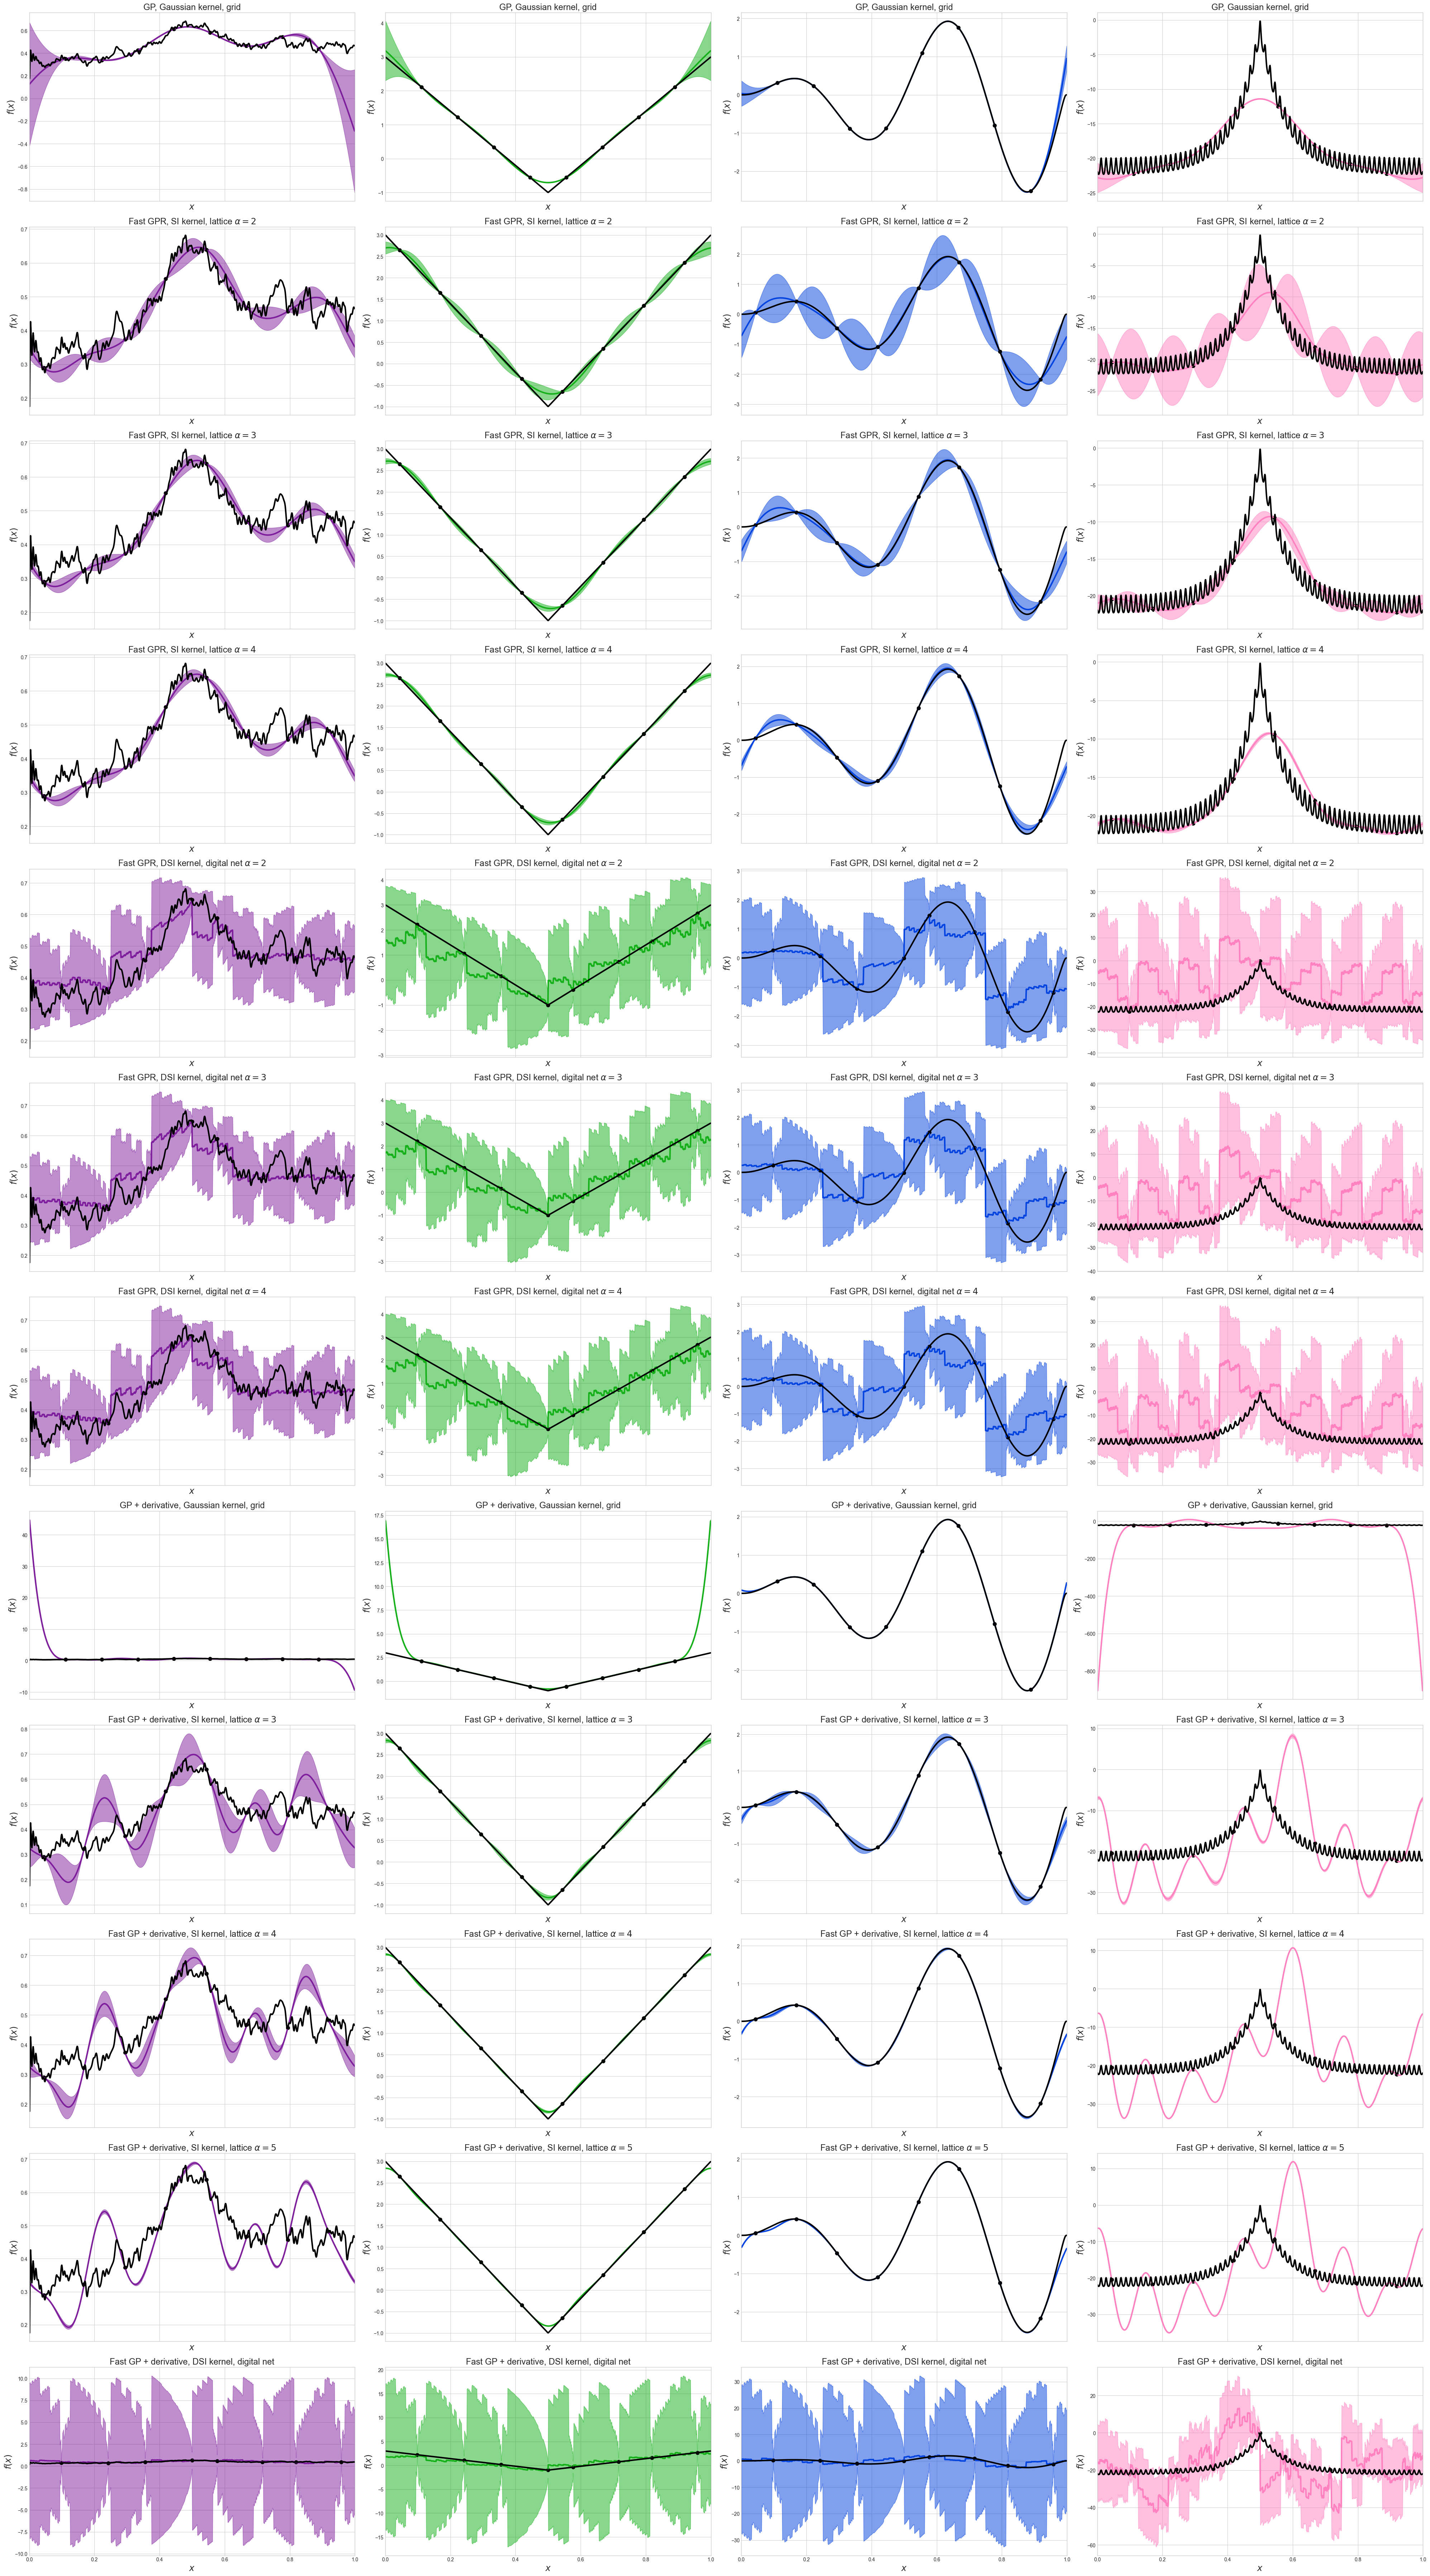

In [27]:
d = 1
n = 2**3
nticks = 1000
xticks = torch.linspace(0,1,nticks+2)[1:-1]
grid = torch.linspace(0,1,n+2)[1:-1,None]
lattice = qp.Lattice(d,seed=7) 
dnb2 = qp.DigitalNetB2(d,seed=7)
lbetas_no_grad = [torch.zeros((1,d),dtype=int,device=DEVICE)]
lbetas_grad = [torch.zeros((1,d),dtype=int,device=DEVICE)]+[ej for ej in torch.eye(d,dtype=int,device=DEVICE)]
gps = [
    ["GP, Gaussian kernel, grid", qp.GPR(grid,lbetas=lbetas_no_grad,device=DEVICE),False],
    [r"Fast GPR, SI kernel, lattice $\alpha = 2$", qp.FGPRLattice(lattice,n,lbetas=lbetas_no_grad,device=DEVICE,alpha=2),False],
    [r"Fast GPR, SI kernel, lattice $\alpha = 3$", qp.FGPRLattice(lattice,n,lbetas=lbetas_no_grad,device=DEVICE,alpha=3),False],
    [r"Fast GPR, SI kernel, lattice $\alpha = 4$", qp.FGPRLattice(lattice,n,lbetas=lbetas_no_grad,device=DEVICE,alpha=4),False],
    [r"Fast GPR, DSI kernel, digital net $\alpha = 2$", qp.FGPRDigitalNetB2(dnb2,n,lbetas=lbetas_no_grad,device=DEVICE,alpha=2),False],
    [r"Fast GPR, DSI kernel, digital net $\alpha = 3$", qp.FGPRDigitalNetB2(dnb2,n,lbetas=lbetas_no_grad,device=DEVICE,alpha=3),False],
    [r"Fast GPR, DSI kernel, digital net $\alpha = 4$", qp.FGPRDigitalNetB2(dnb2,n,lbetas=lbetas_no_grad,device=DEVICE,alpha=4),False],
    ["GP + derivative, Gaussian kernel, grid", qp.GPR(grid,lbetas=lbetas_grad,device=DEVICE), True],
    [r"Fast GP + derivative, SI kernel, lattice $\alpha = 3$", qp.FGPRLattice(lattice,n,lbetas=lbetas_grad,device=DEVICE,alpha=3), True],
    [r"Fast GP + derivative, SI kernel, lattice $\alpha = 4$", qp.FGPRLattice(lattice,n,lbetas=lbetas_grad,device=DEVICE,alpha=4), True],
    [r"Fast GP + derivative, SI kernel, lattice $\alpha = 5$", qp.FGPRLattice(lattice,n,lbetas=lbetas_grad,device=DEVICE,alpha=5), True],
    ["Fast GP + derivative, DSI kernel, digital net", qp.FGPRDigitalNetB2(dnb2,n,lbetas=lbetas_grad,device=DEVICE,alpha=4), True],
]
funcs = [brownian_motion,f_G,f_curve_1d,f_ackley]
ncols = len(funcs)
nrows = len(gps)
fig,ax = pyplot.subplots(nrows=nrows,ncols=ncols,figsize=(10*ncols,6*nrows),sharex=True,sharey=False)
ax = np.atleast_1d(ax).reshape((nrows,ncols))
for j,f in enumerate(funcs):
    yticks = f(xticks[:,None])
    print(f)
    for i,(name,gp,grad) in enumerate(gps):
        print("\t"+name)
        if not grad:
            yf = f(gp.x)[:,None]
        else:
            yf = f_grad_f(f,gp.x)
        data = gp.fit(yf,xticks[:,None],yticks,opt_steps=100,verbose=0,opt_noises=False,lb_noises=1e-8,use_scheduler=True,optimizer_init = lambda params: torch.optim.Adam(params,lr=1e-1,amsgrad=True))
        pmean = gp.post_mean(xticks[:,None])
        ax[i,j].plot(xticks,pmean,color=COLORS[j],linewidth=LW)
        pvar = gp.post_var(xticks[:,None])
        ci_low = pmean-ZSTAR*torch.sqrt(pvar)
        ci_high = pmean+ZSTAR*torch.sqrt(pvar)
        ax[i,j].fill_between(xticks,ci_high,ci_low,color=COLORS[j],alpha=ALPHA)
        ax[i,j].scatter(gp.x[:,0],yf[:,0],color="k",s=MARKERSIZE)
        ax[i,j].plot(xticks,yticks,color="k",linewidth=LW)
        ax[i,j].set_title(name,fontsize="xx-large")
        ax[i,j].set_xlim([0,1])
        ax[i,j].set_xlabel(r"$x$",fontsize="xx-large")
        ax[i,j].set_ylabel(r"$f(x)$",fontsize="xx-large")
fig.tight_layout()
fig.savefig("./fgpr_figs/gp1d.%s.pdf"%name,dpi=256,bbox_inches="tight")

## 2d example

In [30]:
d = 2
n = 2**10
f = f_ackley
nticks = 129
x1ticks = x2ticks = torch.linspace(0,1,nticks+2)[1:-1]
x1mesh,x2mesh = torch.meshgrid(x1ticks,x2ticks,indexing="ij")
xticks = torch.vstack([x1mesh.flatten(),x2mesh.flatten()]).T 
yticks = f(xticks)
ymesh = yticks.reshape(x1mesh.shape)

NameError: name 'f_ackley' is not defined

In [196]:
grid1ticks = grid2ticks = torch.linspace(0,1,int(np.sqrt(n)))
grid1mesh,grid2mesh = torch.meshgrid(grid1ticks,grid2ticks,indexing="ij")
grid = torch.vstack([grid1mesh.flatten(),grid2mesh.flatten()]).T
assert len(grid)==n
lattice = qp.Lattice(d,seed=7) 
dnb2 = qp.DigitalNetB2(d,seed=7)
dnb2_alpha2 = qp.DigitalNetB2(d,seed=7,alpha=2)
dnb2_alpha3 = qp.DigitalNetB2(d,seed=7,alpha=3)
dnb2_alpha4 = qp.DigitalNetB2(d,seed=7,alpha=4)

In [197]:
lbetas_grad = [torch.zeros((1,d),dtype=int,device=DEVICE)]+[ej for ej in torch.eye(d,dtype=int,device=DEVICE)]
gps_grad = [
    ["GP, Gaussian kernel, grid", qp.GPR(grid,lbetas=lbetas_grad,device=DEVICE)],
    ["Fast GP, SI kernel, lattice", qp.FGPRLattice(lattice,n,lbetas=lbetas_grad,device=DEVICE,alpha=3)],
    ["Fast GP, DSI kernel, digital net", qp.FGPRDigitalNetB2(dnb2,n,lbetas=lbetas_grad,device=DEVICE,alpha=4)],
    ["Fast GP, DSI kernel, digital net alpha=2", qp.FGPRDigitalNetB2(dnb2_alpha2,n,lbetas=lbetas_grad,device=DEVICE,alpha=4)],
    ["Fast GP, DSI kernel, digital net alpha=3", qp.FGPRDigitalNetB2(dnb2_alpha3,n,lbetas=lbetas_grad,device=DEVICE,alpha=4)],
    ["Fast GP, DSI kernel, digital net alpha=4", qp.FGPRDigitalNetB2(dnb2_alpha4,n,lbetas=lbetas_grad,device=DEVICE,alpha=4)],
]
for name,gp in gps_grad:
    print(name) 
    yf = f_grad_f(f,gp.x)
    data = gp.fit(yf,
        opt_steps=100,verbose=10,opt_noises=True,lb_noises=1e-12)
    yhat = gp.post_mean(xticks)
    l2rerror = torch.linalg.norm(yhat-yticks)/torch.linalg.norm(yticks)
    print("    L2RError: %.2e"%l2rerror)
    gp.y = yf

GP, Gaussian kernel, grid
        iter of 100 | MLL             L2RError        | lr              | lengthscales, global_scale, noises
    ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
                  0 | 4.63e+15        nan             | 1.00e-01        | [1.00e+00 1.00e+00]	[1.00e+00]	[1.00e-08 1.00e-08 1.00e-08]
                 10 | 2.16e+10        nan             | 1.00e-01        | [2.54e-03 2.54e-03]	[3.94e+02]	[3.94e-06 3.94e-06 3.94e-06]
                 20 | 3.30e+04        nan             | 1.00e-01        | [6.32e-04 6.32e-04]	[1.58e+03]	[1.58e-05 1.58e-05 1.58e-05]
                 30 | 3.26e+04        nan             | 1.00e-01        | [6.02e-04 6.02e-04]	[1.26e+03]	[1.62e-05 5.21e-06 5.21e-06]
                 40 | 3.19e+04        nan             | 1.00e-01        | [5.69e-04 5.69e-04]	[5.33e+02]	[1.35e-05 4.04e-09 4.04e-09]
                 50 | 3.10e+04        nan             | 1.00e-01        | [4.86e-04 4.

In [35]:
CMAP = cm.plasma
nrows = len(gps_grad)
ncols = 3
fig = pyplot.figure(figsize=(3.5*ncols,3.5*nrows))
ax = np.array([[fig.add_subplot(nrows,ncols,ncols*i+j+1,projection="3d") for j in range(ncols)] for i in range(nrows)],dtype=object)
# pmeanmeshes = torch.vstack([gp.post_mean(xticks).reshape(x1mesh.shape)[None,:,:] for _,gp in gps_grad])
# cihwmeshes = np.log10(ZSTAR*torch.sqrt(torch.vstack([gp.post_var(xticks).reshape(x1mesh.shape)[None,:,:] for _,gp in gps_grad])))
# errormeshes = torch.log10(torch.abs(pmeanmeshes-ymesh))
for i,(name,gp) in enumerate(gps_grad):
    pmean_max,pmean_min = pmeanmeshes[i].max(),pmeanmeshes[i].min()
    error_max,error_min = errormeshes[i].max(),errormeshes[i].min()
    cihw_max,cihw_min = cihwmeshes[i].max(),cihwmeshes[i].min()
    norm_pmean = colors.Normalize(vmin=pmean_min,vmax=pmean_max)
    norm_err = colors.Normalize(vmin=error_min,vmax=error_max)
    norm_cihw = colors.Normalize(vmin=cihw_min,vmax=cihw_max)
    surf_func = ax[i,0].plot_surface(x1mesh,x2mesh,pmeanmeshes[i],
        cmap=CMAP,
        #vmin=pmean_min,vmax=pmean_max,
        #facecolors=CMAP(norm_pmean(pmeanmeshes[i])),
        antialiased=False,rstride=1,cstride=1,edgecolor='none')
    surf_cihw = ax[i,1].plot_surface(x1mesh,x2mesh,cihwmeshes[i],
        cmap=CMAP,
        #vmin=cihw_min,vmax=cihw_max,
        #facecolors=CMAP(norm_cihw(cihwmeshes[i])),
        antialiased=True,rstride=1,cstride=1,edgecolor='none')
    surf_err = ax[i,2].plot_surface(x1mesh,x2mesh,errormeshes[i],
        cmap=CMAP,
        #vmin=error_min,vmax=error_max,
        #facecolors=CMAP(norm_err(errormeshes[i])),
        antialiased=True,rstride=1,cstride=1,edgecolor='none')
    cax_pmean = fig.add_axes([
        ax[i,0].get_position().x0,
        ax[i,0].get_position().y1,
        ax[i,0].get_position().x1-ax[i,0].get_position().x0,
        0.025,
    ])
    cax_cihw = fig.add_axes([
        ax[i,1].get_position().x0,
        ax[i,1].get_position().y1,
        ax[i,1].get_position().x1-ax[i,1].get_position().x0,
        0.025,
    ])
    cax_err = fig.add_axes([
        ax[i,2].get_position().x0,
        ax[i,2].get_position().y1,
        ax[i,2].get_position().x1-ax[i,2].get_position().x0,
        0.025,
    ])
    cbar_pmean = fig.colorbar(cm.ScalarMappable(norm=norm_pmean,cmap=CMAP),cax_pmean,orientation="horizontal",label=name)
    cbar_cihw = fig.colorbar(cm.ScalarMappable(norm=norm_cihw,cmap=CMAP),cax_cihw,orientation="horizontal",label="CI half-width")
    cbar_err = fig.colorbar(cm.ScalarMappable(norm=norm_err,cmap=CMAP),cax_err,orientation="horizontal",label="error")
    cbar_err.ax.set_xticklabels([r"$10^{%.1f}$"%tick for tick in cbar_err.ax.get_xticks()])
    cbar_cihw.ax.set_xticklabels([r"$10^{%.1f}$"%tick for tick in cbar_cihw.ax.get_xticks()])
    cbar_err.ax.xaxis.set_label_position('top')
    cbar_cihw.ax.xaxis.set_label_position('top')
    cbar_pmean.ax.xaxis.set_label_position('top')
    #ax[i,0].set_title(name)
for i in range(nrows):
    for j in range(ncols):
        ax[i,j].axis("off")
        ax[i,j].set_xlim([0,1]); ax[i,j].set_xticks([0,1])
        ax[i,j].set_ylim([0,1]); ax[i,j].set_yticks([0,1])
        ax[i,j].xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
        ax[i,j].yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
        ax[i,j].zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
        ax[i,j].xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
        ax[i,j].yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
        ax[i,j].zaxis._axinfo["grid"]['color'] =  (1,1,1,0)
         #ax[i,j].set_xlabel(r"$x_1$",fontsize="xx-large")
        #ax[i,j].set_ylabel(r"$x_2$",fontsize="xx-large")
    ax[i,0].set_zlabel(r"$f(\mathbf{x})$",fontsize="xx-large")
    ax[i,1].set_zlabel(r"$|f(\mathbf{x})-f_{\mathrm{true}}(\mathbf{x})|$",fontsize="xx-large")
    #ax[i,0].set_zlim([pmeanmeshes.min(),pmeanmeshes.max()]); ax[i,j].set_yticks([0,1])
    #ax[i,1].zaxis._set_scale('log')
    #ax[i,1].set_zscale("log",base=10)
#fig.tight_layout()
fig.savefig("./fgpr_figs/fgp_2d.pdf",bbox_inches="tight",dpi=256)

NameError: name 'gps_grad' is not defined

## Speed Comparison

In [31]:
dvec = torch.tensor([1,2,4,8,16,32],dtype=int)
nvec = 2**torch.arange(0,12,dtype=int)
gps = [
    ["GP Gauss lattice", lambda d,n: qp.GPR(qp.Lattice(d),n,lbetas=[torch.zeros(d,dtype=int,device=DEVICE)],device=DEVICE,alpha=2)],
    ["GP Gauss digital net", lambda d,n: qp.GPR(qp.DigitalNetB2(d),n,lbetas=[torch.zeros(d,dtype=int,device=DEVICE)],device=DEVICE,alpha=2)],
    ["GP SI lattice", lambda d,n: qp.FGPRLattice(qp.Lattice(d),n,lbetas=[torch.zeros(d,dtype=int,device=DEVICE)],device=DEVICE,alpha=2)],
    ["GP DSI digital net", lambda d,n: qp.FGPRDigitalNetB2(qp.DigitalNetB2(d),n,lbetas=[torch.zeros(d,dtype=int,device=DEVICE)],device=DEVICE,alpha=2)],
    [r"GP DSI digital net $\alpha = 2$", lambda d,n: qp.FGPRDigitalNetB2(qp.DigitalNetB2(d,alpha=2),n,lbetas=[torch.zeros(d,dtype=int,device=DEVICE)],device=DEVICE,alpha=2)],
    [r"GP DSI digital net $\alpha = 3$", lambda d,n: qp.FGPRDigitalNetB2(qp.DigitalNetB2(d,alpha=3),n,lbetas=[torch.zeros(d,dtype=int,device=DEVICE)],device=DEVICE,alpha=2)],
    [r"GP DSI digital net $\alpha = 4$", lambda d,n: qp.FGPRDigitalNetB2(qp.DigitalNetB2(d,alpha=4),n,lbetas=[torch.zeros(d,dtype=int,device=DEVICE)],device=DEVICE,alpha=2)],
]
print("dvec = %s"%str(dvec.numpy()))
print("nvec = %s"%str(nvec.numpy()))
print()
times = torch.nan*torch.zeros((len(gps),len(dvec),len(nvec)))
l2rerrors = torch.nan*torch.zeros((len(gps),len(dvec),len(nvec)))
for j,d in enumerate(dvec):
    x_test = torch.from_numpy(qp.Halton(d,seed=7)(2**10)).to(DEVICE)
    print("d = %d"%d)
    for i,n in enumerate(nvec):
        print("    n = %d"%n)
        for k,(name,gp_constructor) in enumerate(gps):
            gp = gp_constructor(d,int(n))
            y = f_ackley(gp.x)[:,None]
            y_test = f_ackley(x_test)
            data = gp.fit(y,opt_steps=250,verbose=0,opt_noises=True,lb_noises=1e-12,verbose_indent=8)
            yhat = gp.post_mean(x_test)
            l2rerrors[k,j,i] = torch.linalg.norm(y_test-yhat)/torch.linalg.norm(y_test)
            times[k,j,i] = torch.mean(data["times"][10:-10]-data["times"][9:-11])
            print("        %35s: \tl2 relative error = %-15.2e time = %-15.2e"%(name,l2rerrors[k,j,i],times[k,j,i]))

dvec = [ 1  2  4  8 16 32]
nvec = [   1    2    4    8   16   32   64  128  256  512 1024 2048]

d = 1
    n = 1
                           GP Gauss lattice: 	l2 relative error = 2.92e-01        time = 4.86e-04       
                       GP Gauss digital net: 	l2 relative error = 5.32e-01        time = 4.94e-04       
                              GP SI lattice: 	l2 relative error = 1.11e+00        time = 7.61e-04       
                         GP DSI digital net: 	l2 relative error = 1.00e+00        time = 6.75e-04       
            GP DSI digital net $\alpha = 2$: 	l2 relative error = 9.89e-01        time = 6.65e-04       
            GP DSI digital net $\alpha = 3$: 	l2 relative error = 1.05e+00        time = 6.56e-04       
            GP DSI digital net $\alpha = 4$: 	l2 relative error = 1.03e+00        time = 6.81e-04       
    n = 2
                           GP Gauss lattice: 	l2 relative error = 2.91e-01        time = 5.29e-04       
                       GP Gauss digit

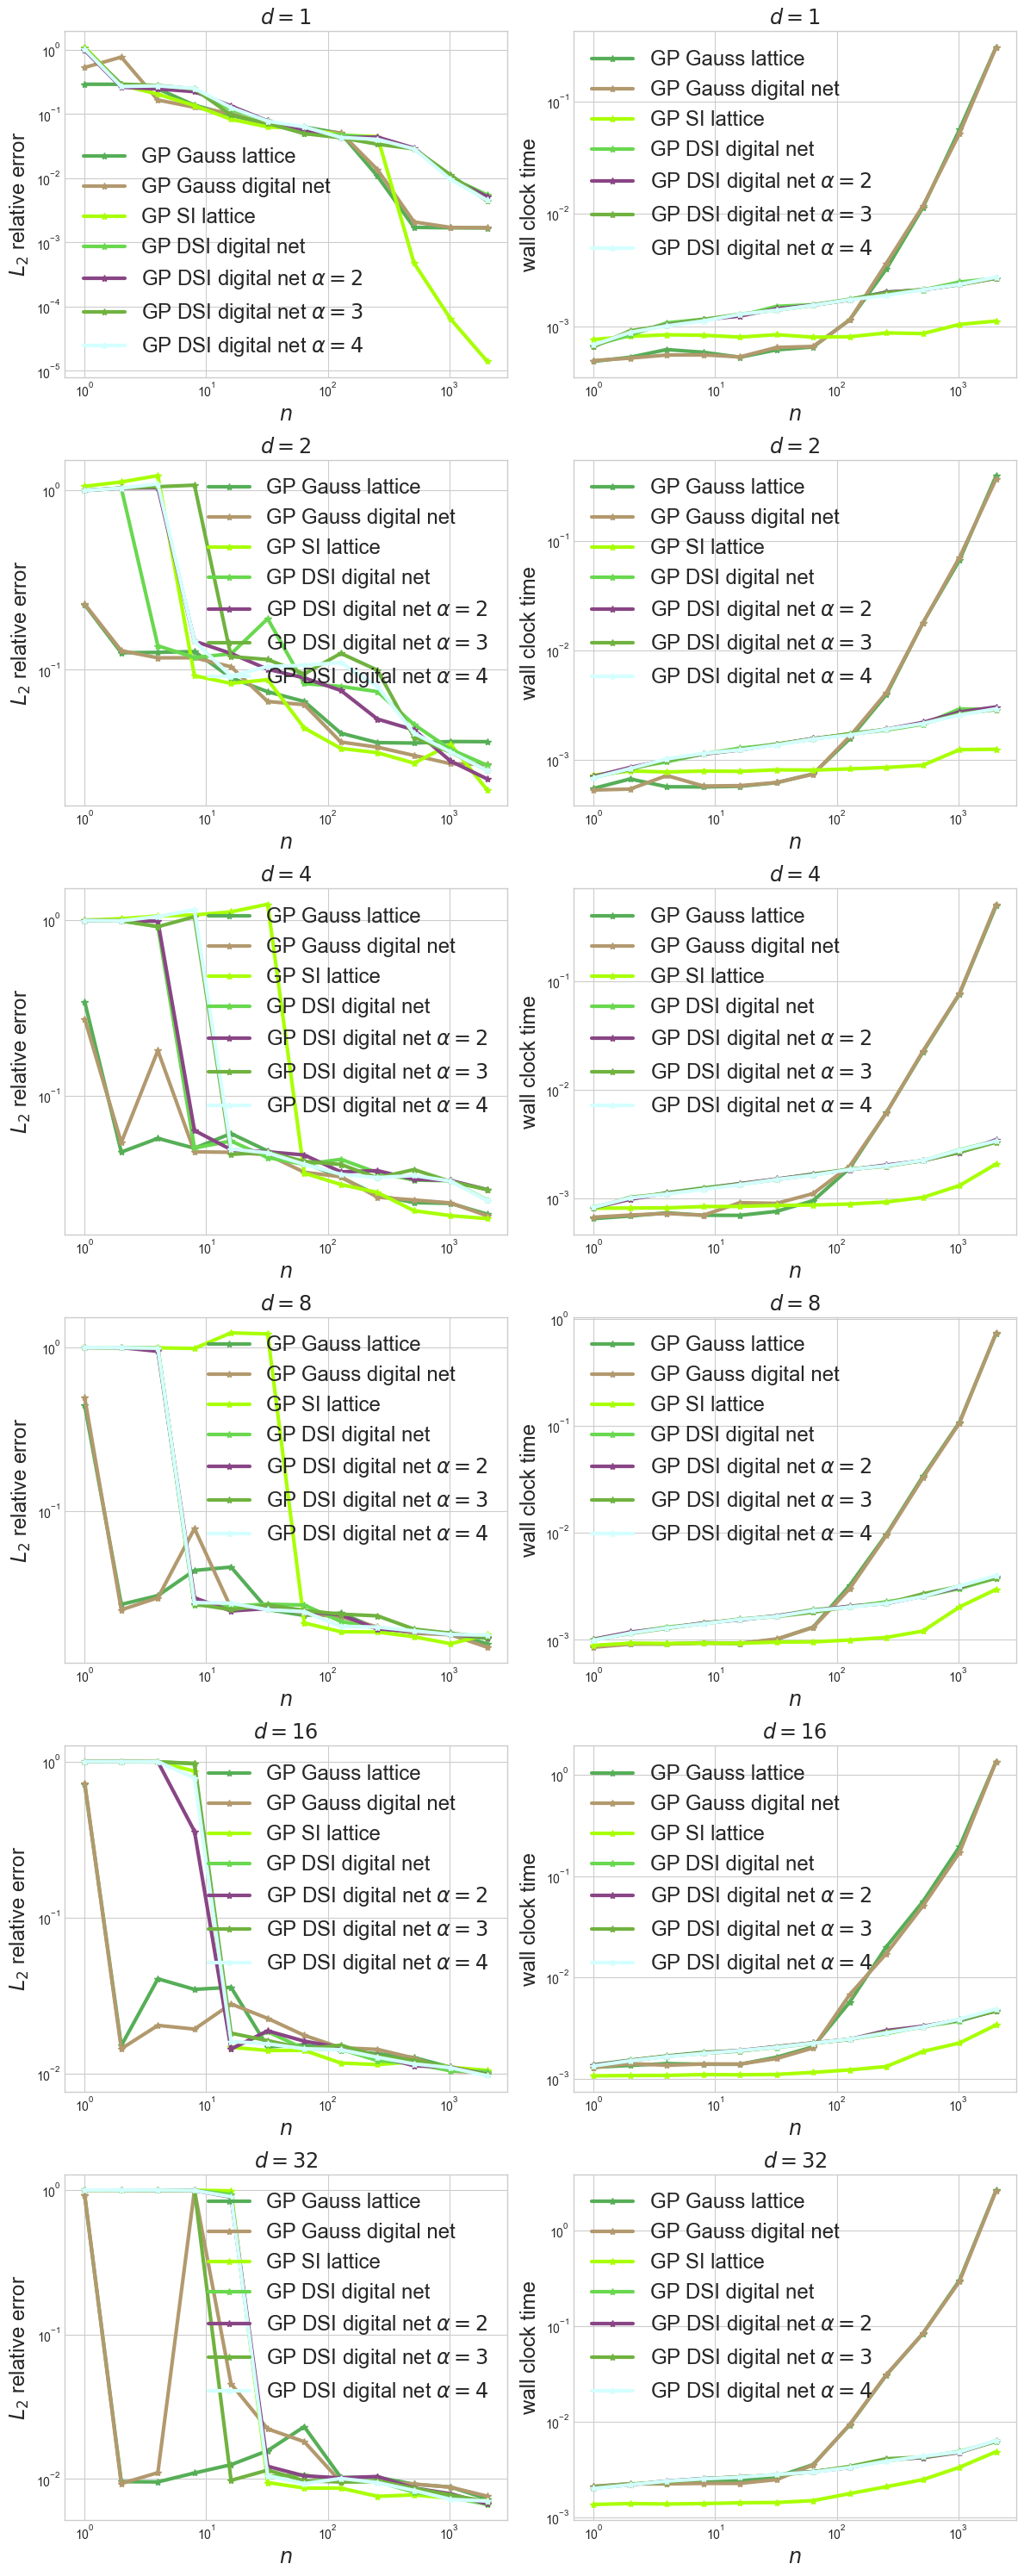

In [33]:
nrows = len(dvec)
ncols = 2
fig,ax = pyplot.subplots(nrows=nrows,ncols=ncols,figsize=(6*ncols,5*nrows))
for j in range(times.size(1)):
    for k in range(times.size(0)):
        ax[j,0].plot(nvec,l2rerrors[k,j],marker="*",color=COLORS[k],label=gps[k][0],linewidth=LW)
        ax[j,1].plot(nvec,times[k,j],marker="*",color=COLORS[k],label=gps[k][0],linewidth=LW)
for j in range(nrows):
    for i in range(ncols):
        ax[j,i].set_xscale("log",base=10)
        ax[j,i].set_yscale("log",base=10)
        ax[j,i].legend(frameon=False,fontsize="xx-large")
        ax[j,i].set_title(r"$d=%d$"%dvec[j],fontsize="xx-large")
    ax[j,0].set_xlabel(r"$n$",fontsize="xx-large")
    ax[j,0].set_ylabel(r"$L_2$ relative error",fontsize="xx-large")
    ax[j,1].set_xlabel(r"$n$",fontsize="xx-large")
    ax[j,1].set_ylabel("wall clock time",fontsize="xx-large")
fig.tight_layout()
